<img src="./images/DLI_Header.png" width=400/>

# Fundamentals of Accelerated Data Science # 

## 06 - XGBoost ##

**Table of Contents**
<br>
This notebook uses use GPU-accelerated gradient boosting to predict the probability that a given individual is infected with the simulated virus. This notebook covers the below sections: 
1. [Environment](#Environment)
2. [Load Data](#Load-Data)
3. [Train-Test Split](#Train-Test-Split)
4. [XGBoost](#XGBoost)
    * [Setting XGBoost Parameters](#Setting-XGBoost-Parameters)
    * [Training the Model](#Training-the-Model)
5. [Inspecting the Model](#Inspecting-the-Model)
6. [Making Predictions](#Making-Predictions)
7. [(Optional) Comparison: CPU-Only XGBoost](#(Optional)-Comparison:-CPU-Only-XGBoost)

## Environment ##
We will be using the [XGBoost](https://xgboost.readthedocs.io/en/latest/) library to create the gradient boosted model for this exercise.

In addition to the usual RAPIDS components, we import several libraries that will help us understand and evaluate the XGBoost model once we have trained it. 

In [1]:
import cudf
import cuml
import cupy as cp

from cuml.model_selection import train_test_split

# visualization
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import graphviz

# model analysis
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import xgboost as xgb

# xgboost version 1.0 or later is required to directly convert from cudf Dataframes to xgboost DMatrix format
print('XGBoost version: ', xgb.__version__)

XGBoost version:  2.1.1


## Load Data ##
For this notebook we load a subset of the population data, including both the columns we used before for logistic regression and the coordinate columns. XGBoost allows us to use data that have nonlinear relationships with the outcome of interest, and geospatial data often fall into that category.

In [2]:
gdf = cudf.read_csv('./data/clean_uk_pop_full.csv', usecols=['age', 'sex', 'northing', 'easting', 'infected'])

In [3]:
gdf.dtypes

age         float64
sex         float64
northing    float64
easting     float64
infected    float64
dtype: object

In [4]:
gdf.shape

(58479894, 5)

In [5]:
gdf.head()

age  sex     northing      easting  infected
0  0.0  0.0  515491.5313  430772.1875       0.0
1  0.0  0.0  503572.4688  434685.8750       0.0
2  0.0  0.0  517903.6563  432565.5313       0.0
3  0.0  0.0  517059.9063  427660.6250       0.0
4  0.0  0.0  509228.6875  425527.7813       0.0

Before splitting the data for training and testing, we check our memory status. We want to be below half the memory usage on the active GPU so that the temporary increase from the split still fits in memory.

In [6]:
!nvidia-smi

Mon May 26 22:43:02 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1B.0 Off |                    0 |
| N/A   32C    P0    28W /  70W |   3618MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            On   | 00000000:00:1C.0 Off |                    0 |
| N/A   

## Train-Test Split ##
We again use the splitting method to create training and testing data subsets, keeping in mind that we will be using additional memory by doing so.

In [7]:
x_train, x_test, y_train, y_test = train_test_split(gdf[['age', 'sex', 'northing', 'easting']], gdf['infected'])

In [8]:
!nvidia-smi

Mon May 26 22:43:07 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1B.0 Off |                    0 |
| N/A   33C    P0    34W /  70W |   7218MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            On   | 00000000:00:1C.0 Off |                    0 |
| N/A   

**Note**: Now that we have training and testing subsets, we can delete the original data so we have room for the algorithm's memory overhead--not critical in this case, but a useful practice when trying to train on as much data as possible.

In [9]:
del(gdf)

## XGBoost ##

### Setting XGBoost Parameters ###
We can now set the parameters for this XGBoost training run. These will determine the type and size of trees being created, as well as the way we measure success. 

The `cuda` device is a critical parameter: it tells XGBoost that we want the training to run on GPU.

For our use case, we again want to predict the probability that an individual is infected with the virus, so we set the `binary:logistic` objective (binary outcome, using the logistic method to get probabilities).

Other parameter options and meanings can be found at [XGBoost parameters](https://xgboost.readthedocs.io/en/latest/parameter.html).

In [ ]:
params = {
    'max_depth': 8,               # Максимальная глубина дерева
    'max_leaves': 2**8,           # Максимальное количество листьев
    'device': 'cuda',             # Использование GPU
    'tree_method': 'hist',        # Метод построения деревьев
    'objective': 'binary:logistic', # Функция потерь для бинарной классификации
    'grow_policy': 'lossguide',   # Стратегия роста деревьев
    'eval_metric': 'logloss',     # Метрика оценки
    'subsample': '0.8'            # Доля случайных подвыборок
}

### Training the Model ###
XGBoost uses a special, highly efficient data structure called a `DMatrix`, so we pass the training dataframes into it to create one.

Note that the data is remaining on GPU, passing directly from cuDF to XGBoost.

In [11]:
dtrain = xgb.DMatrix(x_train, y_train)

Now we are ready to train the model.

In [ ]:
%time model = xgb.train(params, dtrain, num_boost_round=100)
# params — словарь с параметрами обучения
# dtrain — обучающий набор данных, преобразованный в специальный формат DMatrix, который понимает XGBoost.
# numboostround=100 — количество итераций (или количество создаваемых деревьев).
# То есть модель будет строить 100 последовательных деревьев для улучшения качества предсказания.

CPU times: user 17.8 s, sys: 385 ms, total: 18.2 s
Wall time: 17.4 s


In [13]:
model.save_model('xgboost_model.json')

In [14]:
print(x_train)
print(y_train)

           age  sex      northing      easting
40677302  33.0  1.0  309968.18750  442488.9375
12004389  32.0  0.0  175506.06250  530284.8125
25285757  69.0  0.0  291529.25000  391973.7813
995999     2.0  0.0  216216.06250  457507.5313
27794176  80.0  0.0  252553.20310  394617.5000
...        ...  ...           ...          ...
51951620  62.0  1.0  114010.14060  443026.0938
42979337  39.0  1.0  454938.18750  459373.8125
17748799  47.0  0.0   61154.03516  291949.6875
16023406  43.0  0.0  212815.48440  334340.0625
1333152    3.0  0.0  218474.60940  473583.4375

[43859920 rows x 4 columns]
40677302    0.0
12004389    0.0
25285757    0.0
995999      0.0
27794176    0.0
           ... 
51951620    0.0
42979337    0.0
17748799    0.0
16023406    0.0
1333152     0.0
Name: infected, Length: 43859920, dtype: float64


**Note**: As a point of comparison, code to run the CPU-only version of XGBoost is provided at the bottom of this exercise.

## Inspecting the Model ##
We can examine the model in several ways. First, we can see which features the model believes to be most important in its assessment. Higher F scores indicate higher estimated importance.

There appears to be a strong geospatial component to the infection distribution, since the easting and northing features have the highest F scores. In addition, age appears to have a stronger impact than sex in determining infection rates (consistent with the results we received from the logistic regression analysis).

Мы можем исследовать модель несколькими способами. Во-первых, мы можем увидеть, какие характеристики модель считает наиболее важными при своей оценке. Более высокие баллы F указывают на более высокую оценочную важность.

По-видимому, в распространении инфекции присутствует сильная геопространственная составляющая, поскольку объекты восточного и северного направления имеют самые высокие оценки F. Кроме того, возраст, по-видимому, оказывает более сильное влияние, чем пол, на определение уровня заражения (что соответствует результатам, полученным нами в результате логистического регрессионного анализа).

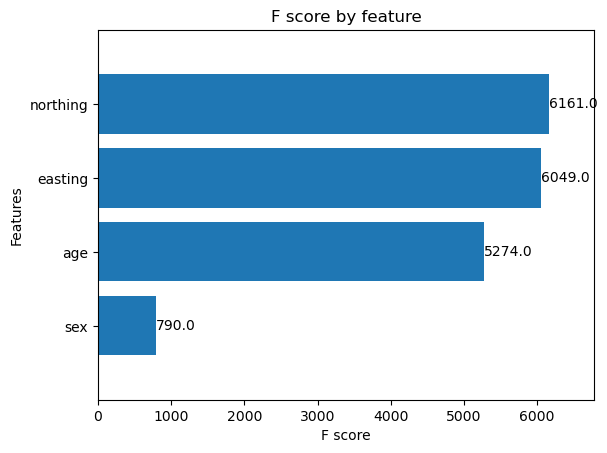

In [15]:
ax = xgb.plot_importance(model, height=.8)
ax.grid(False)
ax.set_title('F score by feature')
plt.show()

We can also pull out individual trees within the model and see exactly which decisions it uses for its contributions to the ensemble. Notice that as with all ensemble methods, individual trees may not appear to produce major differences in outcomes (values on the leaf nodes); the aggregation of often individually-weak trees into a strong model gives XGBoost its power.

Try changing `num_trees` to examine different trees in the model. Changing `rankdir` to `'TB'` will reorient the trees to top-down.

Мы также можем извлечь отдельные деревья из модели и посмотреть, какие именно решения она использует для своего вклада в ансамбль. Обратите внимание, что, как и во всех ансамблевых методах, отдельные деревья могут не давать существенных различий в результатах (значениях на конечных узлах); объединение часто индивидуально слабых деревьев в сильную модель придает XGBoost его мощь.

Попробуйте изменить `num_trees`, чтобы изучить разные деревья в модели. Изменение Rankdir на TB изменит ориентацию деревьев сверху вниз.

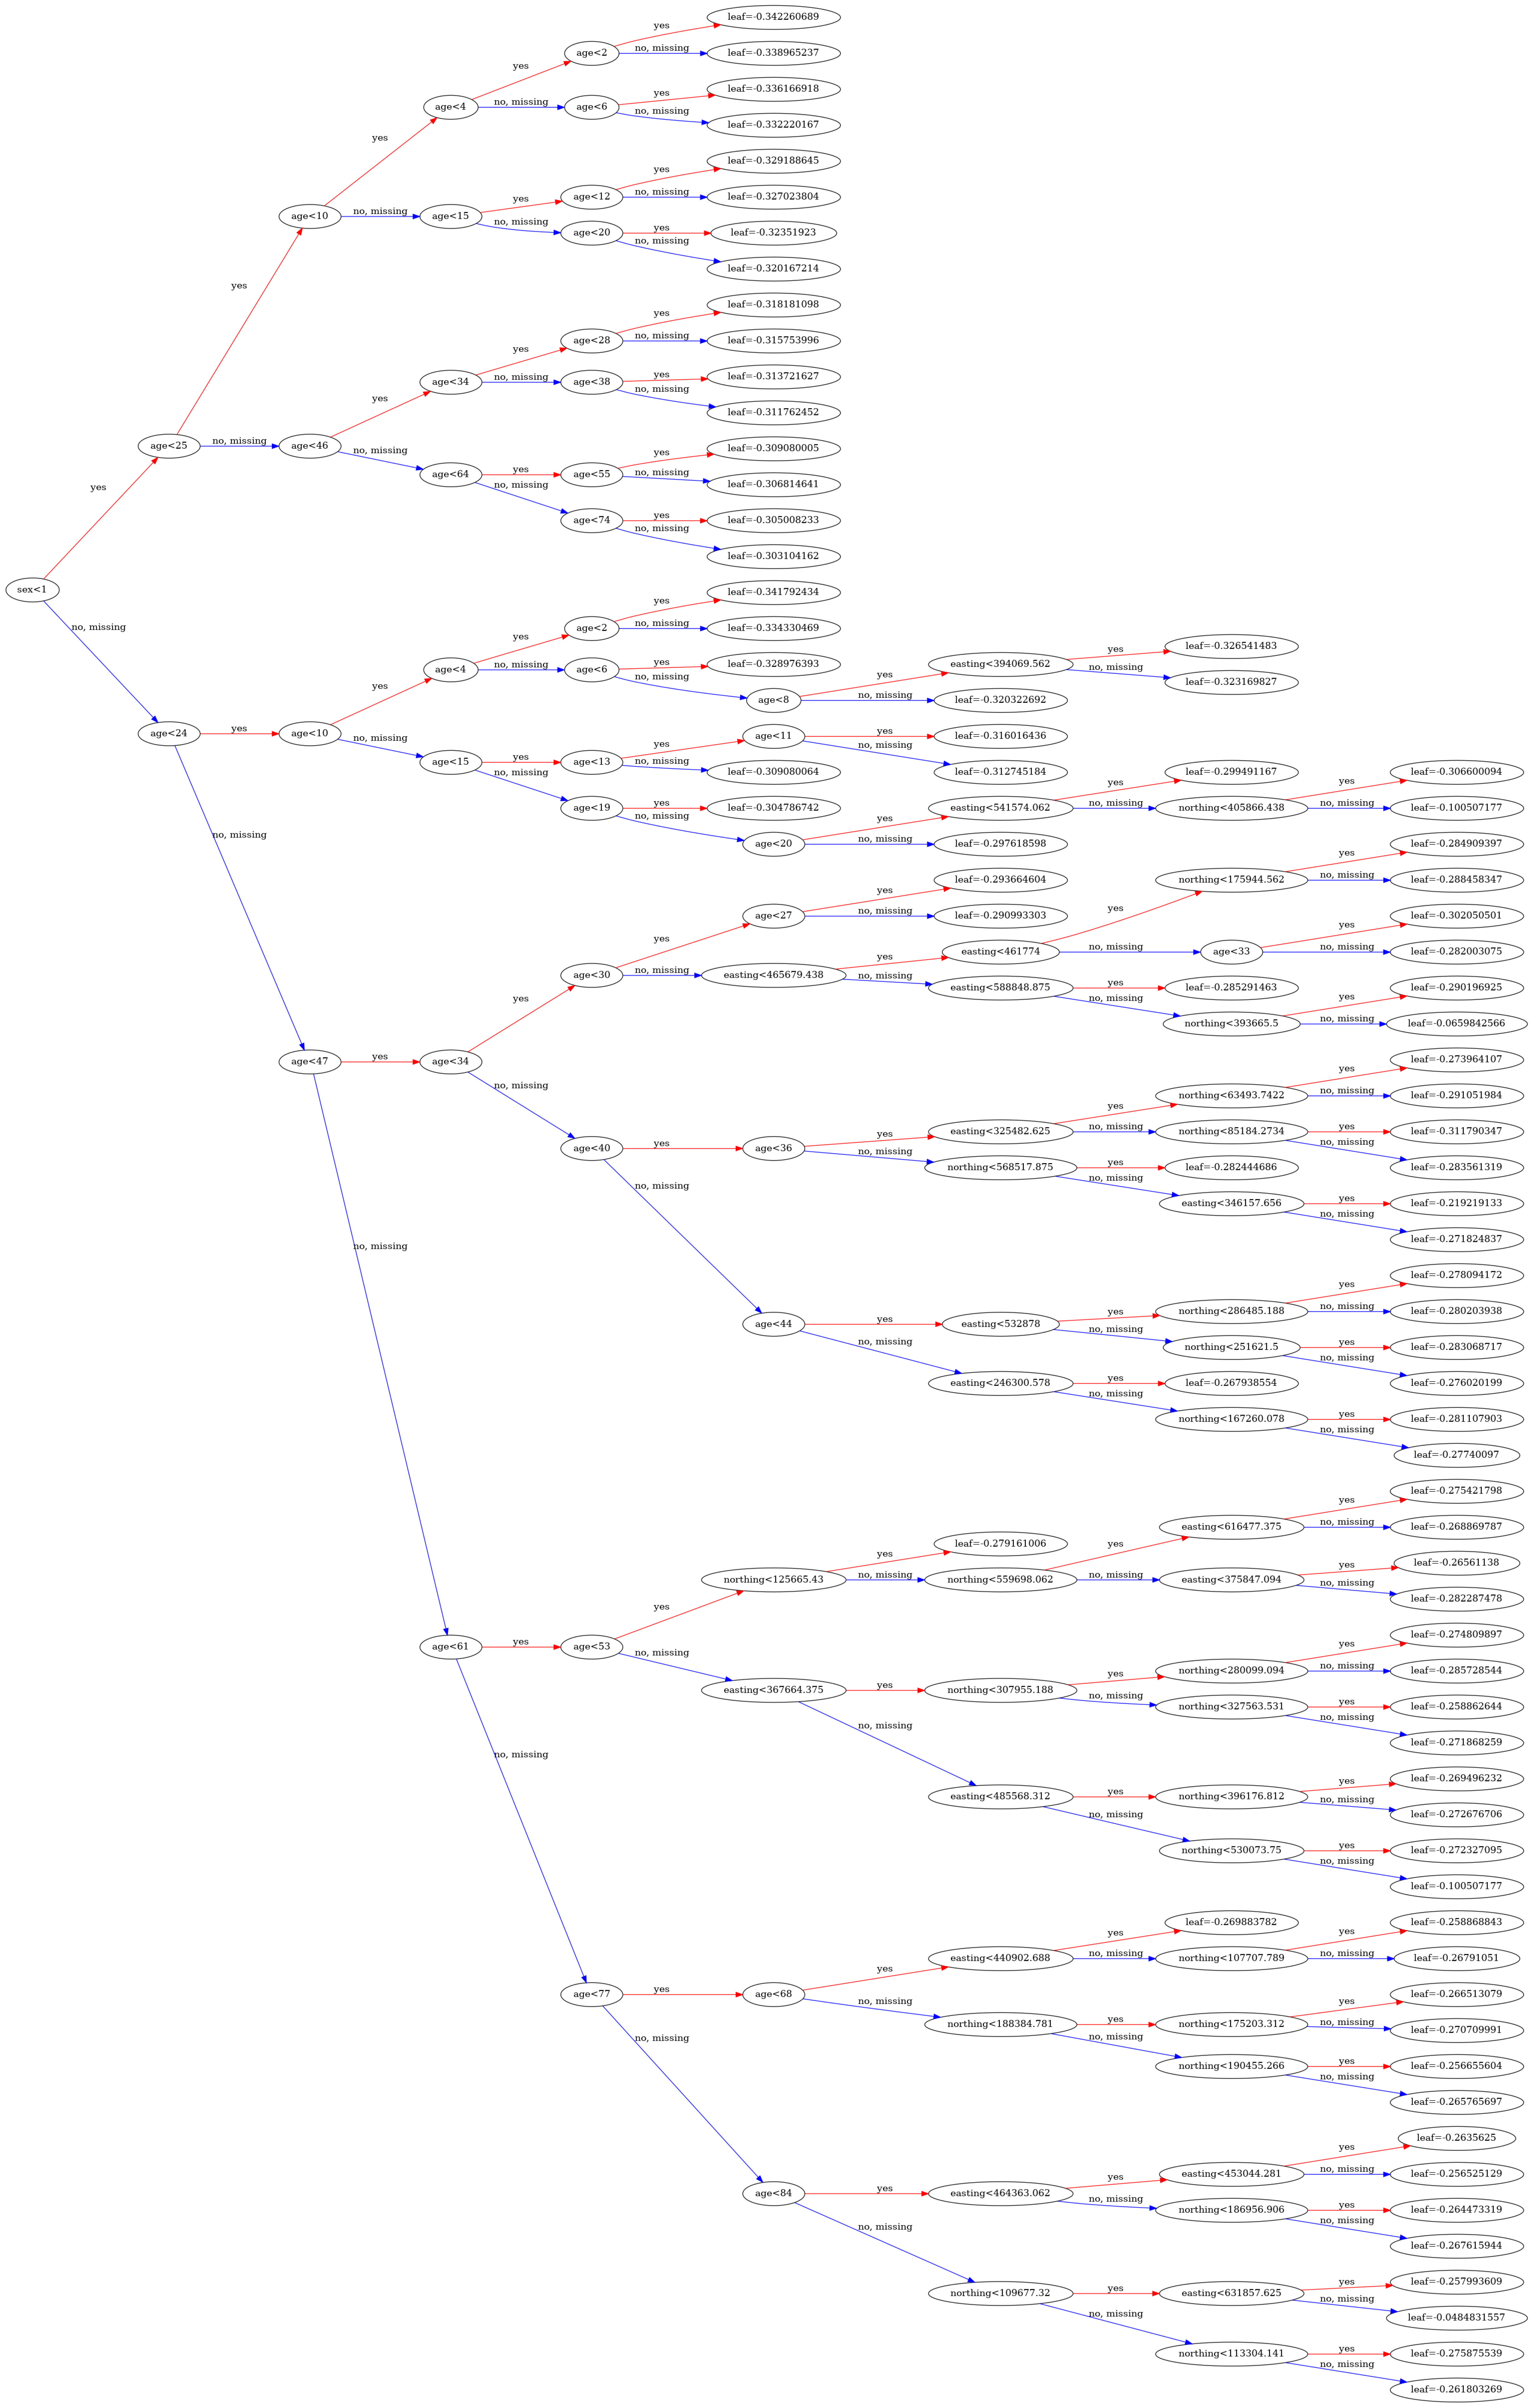

In [ ]:
xgb.plot_tree(model, num_trees=0, rankdir='LR')
# num_trees=0 - берем первое дерево для визуализации (индекс 0)
# get current figure to set the size
fig = matplotlib.pyplot.gcf() # gcf = get current figure
fig.set_size_inches(100, 100)

## Making Predictions ##
Once we are comfortable with the model, we move to making predictions with it. We confirm that we will be making predictions on over 11 million rows of data.

In [17]:
x_test.shape

(14619974, 4)

We convert the *X* matrix to a `DMatrix` as before, then make a prediction for each row. Notice the amount of time it takes to make over 11 million predictions.

In [18]:
dtest = xgb.DMatrix(x_test)
%time y_pred = model.predict(dtest)

CPU times: user 422 ms, sys: 43.5 ms, total: 466 ms
Wall time: 466 ms


Now we would like to see how good those predictions were. One common evaluation method is to calculate the area under the curve (AUC) of the receiver operating characteristic (ROC) curve.

The predictions are a `numpy` array, so we convert the test labels to match, then run the ROC curve calculation.

In [ ]:
y_test_cpu = cp.asnumpy(cp.array(y_test))
false_pos_rate, true_pos_rate, thresholds = roc_curve(y_test_cpu, y_pred)
# y_test_cpu - истинные метки с тестовой выборки
# y_pred - предсказанные вероятности
# thresholds  - массивы порогов при которых вычислялись false_pos_rate и true_pos_rate

Last, we can plot the curve and calculate the AUC score to help us assess the trade offs between true and false positive rates.

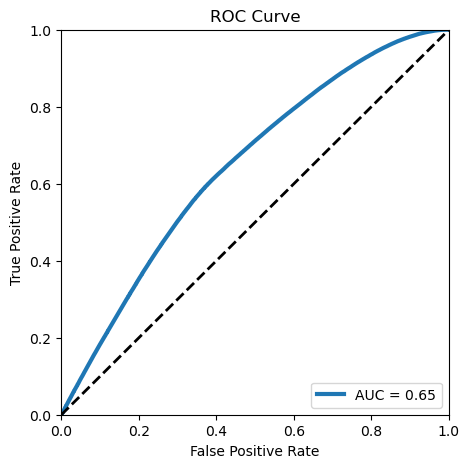

In [ ]:
auc_result = auc(false_pos_rate, true_pos_rate)

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(false_pos_rate, true_pos_rate, lw=3,
        label='AUC = {:.2f}'.format(auc_result))
# толщина линии 3
# В легенде указывается вычисленное значение AUC (до двух знаков после запятой).
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set(
    xlim=(0, 1), # Устанавливаются пределы по осям (от 0 до 1 для обеих осей).
    ylim=(0, 1),
    title="ROC Curve",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend(loc='lower right');
plt.show()

## (Optional) Comparison: CPU-Only XGBoost ##
Below we provide code for training and inferring from a CPU-only XGBoost using the same model parameters other than switching the histogram tree method from GPU to CPU.

In [21]:
params['device'] = 'cpu'
dtrain_cpu = xgb.DMatrix(x_train.to_pandas(), y_train.to_pandas())
%time model_cpu = xgb.train(params, dtrain_cpu, num_boost_round=100)

CPU times: user 27min 43s, sys: 17.3 s, total: 28min
Wall time: 1min 2s


In [22]:
dtest_cpu = xgb.DMatrix(x_test.to_pandas())
%time y_pred_cpu = model_cpu.predict(dtest_cpu)

CPU times: user 1min 5s, sys: 53.5 ms, total: 1min 5s
Wall time: 1.46 s


In [23]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

**Well Done!** Let's move to the [next notebook](3-07_triton.ipynb). 

<img src="./images/DLI_Header.png" width=400/>